In [2]:
import pandas as pd
import numpy as np
from itertools import chain
from scipy.stats import chi2_contingency
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from pybedtools import BedTool as pbt

### 1. Call loops

In [16]:
#set path to the merged sampled maps
path_to_maps = "../data/"
binsize = 10_000
clr_HCmin_10 = cooler.Cooler(f'{path_to_maps}/NeuNminus.sampled.1000.mcool::/resolutions/{binsize}')
clr_HCplus_10 = cooler.Cooler(f'{path_to_maps}/NeuNplus.sampled.1000.mcool::/resolutions/{binsize}')
clrs_10 = [clr_HCplus_10, clr_HCmin_10]

In [18]:
n_proc = 10
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

In [3]:
expected_HCmin_10 = cooltools.expected_cis(
    clr_HCmin_10,
    view_df=hg38_arms,
    nproc=n_proc,
)
expected_HCplus_10 = cooltools.expected_cis(
    clr_HCplus_10,
    view_df=hg38_arms,
    nproc=n_proc,
)
expected_HCplus_10.to_csv("../data/expected_HCplus_10.csv", index=False)
expected_HCmin_10.to_csv("../data/expected_HCmin_10.csv", index=False)

dots_df_HCplus_10_ext = cooltools.dots(
    clr_HCplus_10,
    expected=expected_HCplus_10,
    view_df=hg38_arms,
    max_loci_separation=6_000_000,
    max_nans_tolerated=2,
  
    lambda_bin_fdr=0.05,
    clustering_radius=20_000,
    cluster_filtering=None,
    tile_size=5_000_000,
    nproc=15,
)

dots_df_HCmin_10_ext = cooltools.dots(
    clr_HCmin_10,
    expected=expected_HCmin_10,
    view_df=hg38_arms,
    max_loci_separation=6_000_000,
    max_nans_tolerated=2,
  
    lambda_bin_fdr=0.05,
    clustering_radius=20_000,
    cluster_filtering=None,
    tile_size=5_000_000,
    nproc=15,
)

In [15]:
dots_df_HCplus_10_ext["loop_num"] = range(1,dots_df_HCplus_10_ext.shape[0] + 1)
dots_df_HCmin_10_ext["loop_num"] = range(1,dots_df_HCmin_10_ext.shape[0] + 1)
dots_df_HCmin_10_ext = dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2" , 'loop_num']]
dots_df_HCplus_10_ext = dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2" , 'loop_num']]

def save_loops(format = 'tsv'):
    if format == 'csv':
        dots_df_HCplus_10_ext.to_csv("../data/dots_df_HCplus_10_ext.csv", index=False)
        dots_df_HCmin_10_ext.to_csv("../data/dots_df_HCmin_10_ext.csv", index=False)
    elif format == 'tsv':
        dots_df_HCplus_10_ext.to_csv("../data/dots_df_HCplus_10_ext_maps112022.tsv", sep="\t", index=False)
        dots_df_HCmin_10_ext.to_csv("../data/dots_df_HCmin_10_ext_maps112022.tsv",  sep="\t", index=False)

save_loops(format = 'csv')
save_loops(format = 'tsv')

### 2. Inspect general properties

In [87]:
dots_df_HCplus_10_ext= pd.read_csv("../data/dots_df_HCplus_10_ext_maps112022.tsv", sep="\t")
dots_df_HCmin_10_ext= pd.read_csv("../data/dots_df_HCmin_10_ext_maps112022.tsv",  sep="\t")
dots_df_HCplus_10_ext["cell_type"] = "NeuN+"
dots_df_HCmin_10_ext["cell_type"] = "NeuN-"
all_loops_10_ext = pd.concat([dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]],
                              dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]]]).drop_duplicates().reset_index(drop=True)
clrs_10 = [clr_HCplus_10, clr_HCmin_10]
exps_10 = [expected_HCplus_10 , expected_HCmin_10]

In [ ]:
avr_loops, avr_loops_all = [], []
for i in range(2):    
    stack = cooltools.pileup(clrs_10[i], 
                                all_loops_10_ext, 
                                 hg38_arms,                                 
                                 expected_df=exps_10[i], 
                                 flank=200000,
                                 nproc=10)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    avr_loops_all.append(stack)
    avr_loops.append(np.nanmean(stack, axis=0))

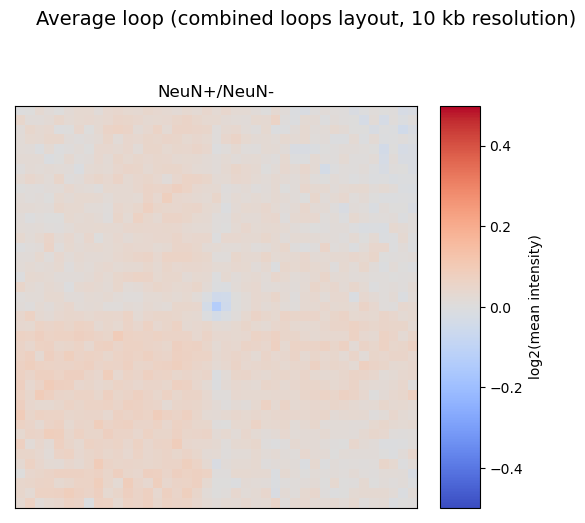

In [49]:
plt.rcParams['axes.facecolor'] = 'white'
fig, axs = plt.subplots(1, 2,figsize=(6,6), 
                        gridspec_kw={'width_ratios': [1, 0.1] , 'wspace':0.1})
vmin=-0.5
vmax=0.5
im = axs[0].imshow(np.log(avr_loops[0]/ avr_loops[1]), cmap='coolwarm',
                vmin = vmin, vmax = vmax )
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('NeuN+/NeuN-')
plt.colorbar(im, cax=axs[1])
axs[1].set_box_aspect(10) # adjust colorbar height
axs[1].set_ylabel("log2(mean intensity)")
plt.suptitle('Average loop (combined loops layout, 10 kb resolution)', fontsize = 14, x=0.61,y = 0.99);


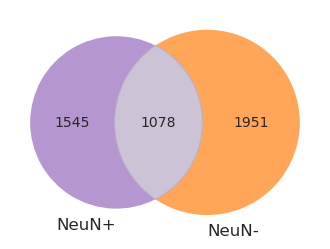

In [52]:
sns.set_style("white")
plt.figure(figsize=(4,4))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
c = venn2(subsets = (1545,1951, 1078), 
          set_labels = ('NeuN+', 'NeuN-'),
         set_colors=(sns.color_palette()[4],sns.color_palette()[1]),alpha=0.69)
c.get_patch_by_id('11').set_color('#b7a9c4')
plt.show()

Text(0.5, 0, 'Cell type')

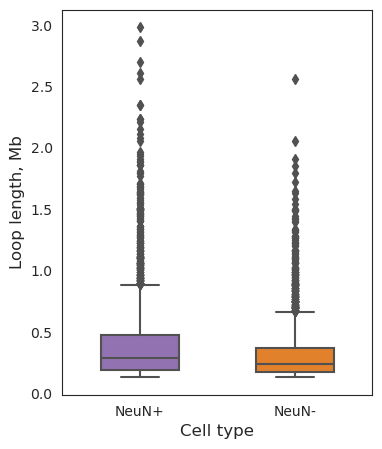

In [88]:
sns.set_style("white")
plt.figure(figsize=(4,5))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
ax= sns.boxplot(data=all_loops_10_ext, x="cell_type", y="loop_length_mb",  width=0.5,
                showmeans=False, palette=my_pal, 
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"} );
plt.ylabel("Loop length, Mb", size=12)
plt.xlabel("Cell type", size=12)

### 3. Identify loops groups

In [9]:
all_loops_10_ext_hic_plus = []
stack = cooltools.pileup(clrs_10[0], 
                             all_loops_10_ext, 
                             hg38_arms,                                 
                             expected_df=exps_10[0], 
                             flank=200000,
                             nproc=12)

stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
all_loops_10_ext_hic_plus.append(stack)
all_loops_10_ext_hic_plus = all_loops_10_ext_hic_plus[0]


In [10]:
all_loops_10_ext_hic_plus_20_20 = []
for i in range(all_loops_10_ext_hic_plus.shape[0]):
    all_loops_10_ext_hic_plus_20_20.append(all_loops_10_ext_hic_plus[i][20,20])

In [11]:
all_loops_10_ext_hic_minus = []
stack = cooltools.pileup(clrs_10[1], 
                             all_loops_10_ext, 
                             hg38_arms,                                 
                             expected_df=exps_10[1], 
                             flank=200000,
                             nproc=12)

stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
all_loops_10_ext_hic_minus.append(stack)
all_loops_10_ext_hic_minus = all_loops_10_ext_hic_minus[0]


In [12]:
all_loops_10_ext_hic_minus_20_20 = []
for i in range(all_loops_10_ext_hic_minus.shape[0]):
    all_loops_10_ext_hic_minus_20_20.append(all_loops_10_ext_hic_minus[i][20,20])

In [13]:
all_loops_10_ext_hic = [i/k for i, k in zip(all_loops_10_ext_hic_plus_20_20, all_loops_10_ext_hic_minus_20_20)]
all_loops_10_ext["NeuN+"] = all_loops_10_ext_hic_plus_20_20
all_loops_10_ext["NeuN-"] = all_loops_10_ext_hic_minus_20_20
all_loops_10_ext["NeuN+/NeuN-"] = all_loops_10_ext_hic

In [14]:
groups = np.quantile(np.array(all_loops_10_ext["NeuN+/NeuN-"].tolist()), [0,0.25,0.5,0.75,1])
print(groups)
loops_groups = []
for item in all_loops_10_ext["NeuN+/NeuN-"].tolist():
    if item <=groups[1]:
        loops_groups.append(0)
    if item <=groups[2] and item > groups[1]:
        loops_groups.append(1)
    if item <=groups[3] and item > groups[2]:
        loops_groups.append(2)
    if item > groups[3]:
        loops_groups.append(3)
all_loops_10_ext["loop_group"] = loops_groups

In [78]:
loops_cooltools_groups = []
num_groups = []
for group in [0,1,2,3]:
    ind_list = all_loops_10_ext[all_loops_10_ext.loop_group == group].index.tolist() 
    loops_cooltools_groups_ind = []
    for i in ind_list:
        loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])
    loops_cooltools_groups_ind = np.array(loops_cooltools_groups_ind)
    loops_cooltools_groups_ind[np.isinf(loops_cooltools_groups_ind)] = np.nan
    loops_cooltools_groups.append(np.nanmean(loops_cooltools_groups_ind, axis=0))
    num_groups.append(len(ind_list))

/tmp/ipykernel_808099/2747411422.py:7: RuntimeWarning: divide by zero encountered in divide
  loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])
/tmp/ipykernel_808099/2747411422.py:7: RuntimeWarning: invalid value encountered in divide
  loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])


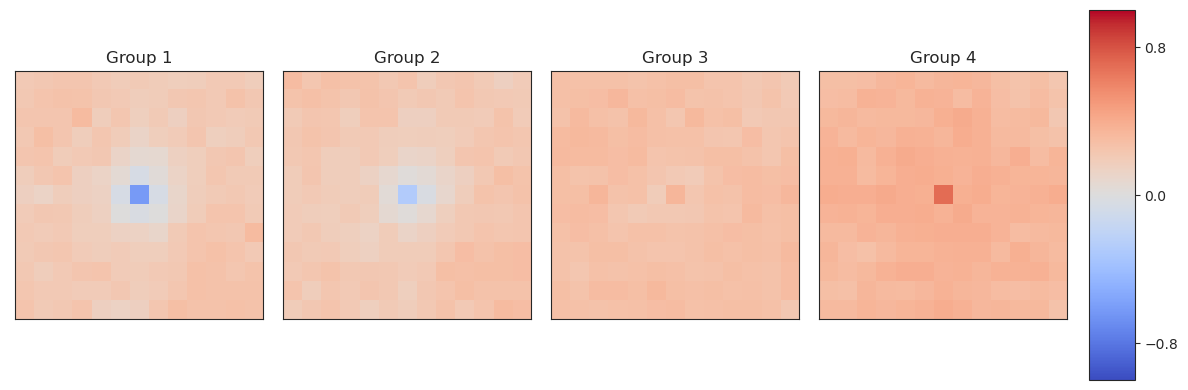

In [79]:
a=14
sns.set_style("ticks")
fig, axs = plt.subplots(1, 5, figsize=(12,4), 
                        gridspec_kw={'width_ratios': [1, 1, 1,1, 0.2]})
cnt=0
n_count = 0
for i in range(4):
        im = axs[i].imshow(np.log(loops_cooltools_groups[cnt][0+a:-a, 0+a:-a]), 
                              cmap='coolwarm',
                              vmin=-1, vmax=1)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        cnt+=1
        n_count+=1
vmin=-0.8
vmax=0.8
axs[0].set_title('Group 1');
axs[1].set_title('Group 2');
axs[2].set_title('Group 3');
axs[3].set_title('Group 4');
plt.colorbar(im, cax=axs[4], ticks = [vmin, 0 , vmax])
axs[4].set_box_aspect(8) 
plt.tight_layout()
plt.subplots_adjust( hspace=0.05)  

### 4. Map with chromatin states

In [4]:
states = ['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']
all_loops_10_ext["loop_num"] = range(1,all_loops_10_ext.shape[0] + 1)

In [5]:
def loop_annotation_ratio(dots_df_HCplus_5_ext_left, ChromHMM_Neuron, shuffled = False):  
    dots_df_HCplus_5_ext_left= dots_df_HCplus_5_ext_left[["chrom1","start1","end1","loop_num","loop_group"]]   
    colnames = dots_df_HCplus_5_ext_left.columns.tolist() + ChromHMM_Neuron.columns.tolist()
    dots_df_HCplus_5_ext_left_states = pbt.from_dataframe(dots_df_HCplus_5_ext_left)\
                                    .intersect(pbt.from_dataframe(ChromHMM_Neuron), wa=True, wb=True)
    dots_df_HCplus_5_ext_left_states = pd.read_table(dots_df_HCplus_5_ext_left_states.fn, header = None, names=colnames)
    for i in range(dots_df_HCplus_5_ext_left_states.shape[0]):
        if dots_df_HCplus_5_ext_left_states.iloc[i].end > dots_df_HCplus_5_ext_left_states.iloc[i].end1:
            dots_df_HCplus_5_ext_left_states.loc[i, "end"] = dots_df_HCplus_5_ext_left_states.iloc[i].end1

        if dots_df_HCplus_5_ext_left_states.iloc[i].start < dots_df_HCplus_5_ext_left_states.iloc[i].start1:
            dots_df_HCplus_5_ext_left_states.loc[i, "start"] = dots_df_HCplus_5_ext_left_states.iloc[i].start1
    return dots_df_HCplus_5_ext_left_states

def cal_mean(dots_df_HCplus_5_ext_left_states):
    state_lengthes_df = pd.DataFrame(states, columns = ["state"])
    for i in dots_df_HCplus_5_ext_left_states.loop_num.tolist():   
        df = dots_df_HCplus_5_ext_left_states[dots_df_HCplus_5_ext_left_states.loop_num.isin([i])].copy()
        df["feature_length"] = df["end"] - df["start"] 
        tad_size = (df["end1"]- df["start1"]).tolist()[0]
        state_lengthes = []
        for state in states:
            state_lengthes.append(sum(df[df["state"] == state].feature_length.tolist())/ tad_size)
        state_lengthes_df[i] = state_lengthes   
    coeff = 1/ sum(state_lengthes_df.iloc[:,1:].mean(axis=1))
    means = [ i* coeff for i in state_lengthes_df.iloc[:,1:].mean(axis=1).tolist()]
    state_lengthes_df["mean"] = means
    return state_lengthes_df

def ann_loop(border_plus_ann_plus, ChromHMM_Neuron, shuffled = False):
    border_common_ann_plus_minus_ann = loop_annotation_ratio(border_plus_ann_plus, ChromHMM_Neuron, shuffled = False)
    dict_df = {}
    for i in [0,1,2,3]:
        border1 = border_common_ann_plus_minus_ann[border_common_ann_plus_minus_ann.loop_group == i]
        state_lengthes_df = cal_mean(border1)
        dict_df[i] = state_lengthes_df    
    return dict_df    


In [8]:
ChromHMM_Neuron = pd.read_table("../data/ChromHMM_Neuron.bed", sep="\t",header = None)
ChromHMM_NonNeuron = pd.read_table("../data/ChromHMM_NonNeuron.bed", sep="\t",header = None)
ChromHMM_NonNeuron.columns = ["chrom","start","end", "state", "smth","strand","f1","f2","f3"]
ChromHMM_Neuron.columns = ["chrom","start","end", "state", "smth","strand","f1","f2","f3"]

In [46]:
def make_overall_coverage(ChromHMM_NonNeuron):
    ChromHMM_NonNeuron['legnth'] = ChromHMM_NonNeuron['end']- ChromHMM_NonNeuron['start']
    state_lengthes_df_glia = ChromHMM_NonNeuron[['state','legnth']].groupby('state').sum() / ChromHMM_NonNeuron["legnth"].sum()
    state_lengthes_df_glia.reset_index(inplace= True)
    state_lengthes_df_glia.columns = ['state', 'state_cov']
    return state_lengthes_df_glia

def make_df_for_plot(norm, dict_df):
    df_full = pd.DataFrame(norm.state.to_list(), columns = ["state"])
    for i in [3,2,1,0]:
        df = dict_df[i][["state","mean"]].copy()
        df["mean"] = df["mean"]/ norm["state_cov"]
        df = df.rename(columns = {"mean":f"Group {i+1}"})
        df_full = df.merge(df_full, on ="state")
    df_full_long = pd.melt(df_full, id_vars='state', value_vars=df_full.columns.tolist()[1:])
    df_full_long["log2value"] = np.log2(df_full_long["value"])
    return df_full_long
    
def get_palette():
    my_pal = {}
    states = [ 'TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']
    cols = ['crimson','salmon',  'orange','indianred',  'grey','lightgrey']
    for state, col in zip(states, cols):
        my_pal[state] =col  
    return my_pal

def plot_states(df_full_long_minus):
    my_pal = get_palette()
    sns.set_theme(style="whitegrid",font_scale=1.52)
    g = sns.catplot(
        data=df_full_long_minus, kind="bar",
        x="variable", y="log2value", hue="state", height=6.27, aspect=16.7/8.27,
        palette=my_pal, alpha=0.98
    )
    g.despine(left=True)
    g.set_axis_labels("", "log2 (ratio)")
    ticks = [-1, 0, 1, 2,  3]
    for axes in g.axes.flat:
        _ = axes.set_yticks(ticks)
        _ = axes.set_yticklabels(ticks)

In [10]:
all_loops_10_ext_ann_plus = ann_loop(all_loops_10_ext, ChromHMM_Neuron)
all_loops_10_ext_ann_minus = ann_loop(all_loops_10_ext, ChromHMM_NonNeuron)

In [11]:
state_lengthes_df_glia = make_overall_coverage(ChromHMM_NonNeuron)
state_lengthes_df_neurons = make_overall_coverage(ChromHMM_Neuron)
state_lengthes_df_glia = state_lengthes_df_glia.set_index("state").reindex(all_loops_10_ext_ann_minus[0].state.tolist()).reset_index()
state_lengthes_df_neurons = state_lengthes_df_neurons.set_index("state").reindex(all_loops_10_ext_ann_plus[0].state.tolist()).reset_index()


In [48]:
df_full_long_plus = make_df_for_plot( state_lengthes_df_neurons, all_loops_10_ext_ann_plus)
df_full_long_minus = make_df_for_plot(state_lengthes_df_glia, all_loops_10_ext_ann_minus)

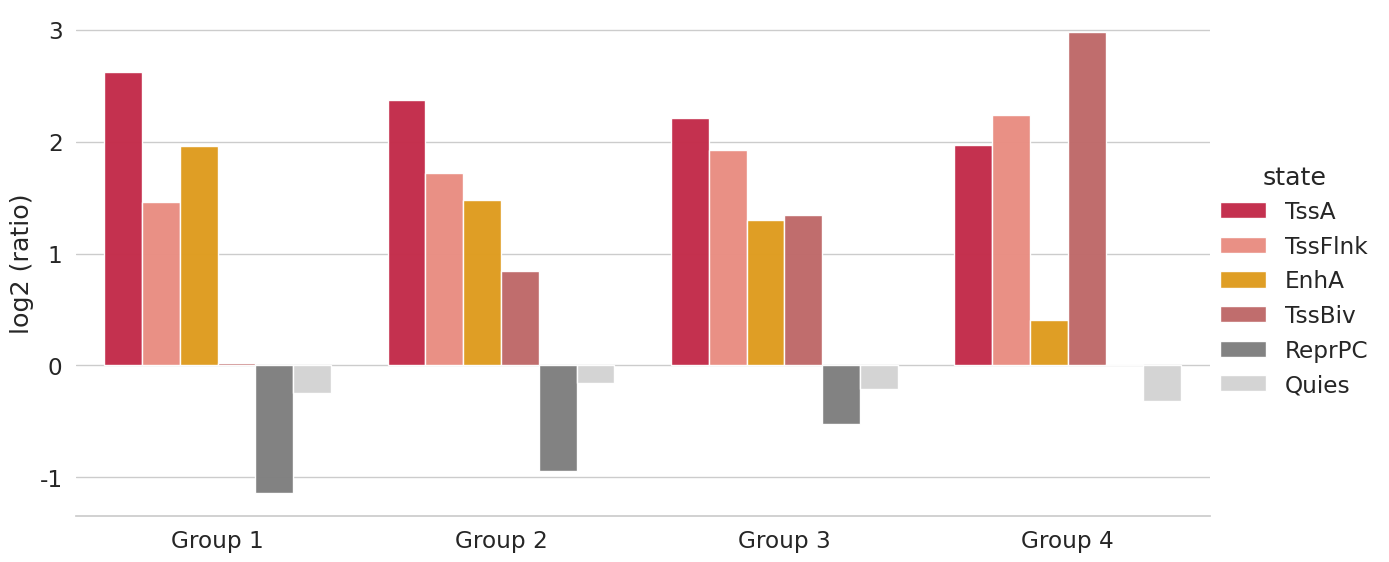

In [49]:
plot_states(df_full_long_minus)

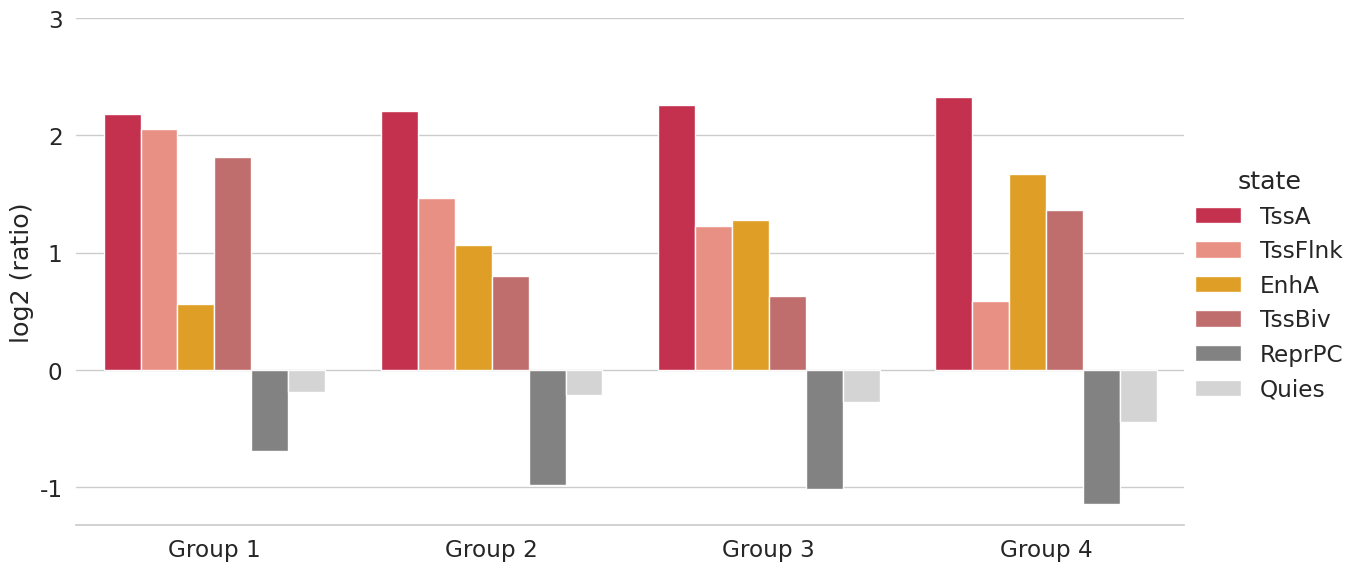

In [50]:
plot_states(df_full_long_plus)

### 5. Study loops properties

#### Identify TSS

In [131]:
genes_annotation = pd.read_csv("../data/GENCODE.v41.annotation.bed", sep="\t", header= None)
rizzardi2019_counts = pd.read_csv("../data/rnaseq.rizzardi2019.counts.GENCODE.autosomes_and_chrX.with_meta.tsv.gz", sep ='\t')
de_neurons = pd.read_csv("../data/rizzardi.pc_DE_genes.upr_in_neu.bed", sep="\t",header= None)
de_glia = pd.read_csv("../data/rizzardi.pc_DE_genes.upr_in_gli.bed", sep="\t",header= None)
genes_annotation.columns = ["chrom","start","end","gene.id", "f1", "strand"]
rizzardi2019_counts = genes_annotation[["chrom","start","end", "strand","gene.id"]].merge(rizzardi2019_counts.drop(columns = ["chrom"]), on = "gene.id")

In [160]:
columns_samples = [col for col in rizzardi2019_counts.columns if col.startswith('X')]
rizzardi2019_counts_expressed_genes = rizzardi2019_counts[rizzardi2019_counts[columns_samples].sum(axis=1) > 5].reset_index(drop=True)
rizzardi2019_counts_expressed_genes = rizzardi2019_counts_expressed_genes[["chrom","start","end","gene.name", "gene.type","strand"]]

In [164]:
columns = ["chrom","start","end","gene.name", "gene.id","strand"]
columns2 = ['chrom', 'start', 'end', 'gene.name', 'log2FC', 'strand']
chrom_sizes_path = '../data/hg38.chrom.sizes' 
tss_plus = pbt.from_dataframe(de_neurons).flank(g=chrom_sizes_path, s=True, l=2000, r=0)
tss_plus = pd.read_table(tss_plus.fn, header = None, names=columns2)

tss_glia = pbt.from_dataframe(de_glia).flank(g=chrom_sizes_path, s=True, l=2000, r=0)
tss_glia = pd.read_table(tss_glia.fn, header = None, names=columns2)

tss_expr = pbt.from_dataframe(rizzardi2019_counts_expressed_genes).flank(g=chrom_sizes_path, s=True, l=2000, r=0)
tss_expr = pd.read_table(tss_expr.fn, header = None, names=columns)


#### Make intersection

In [180]:
def make_intersect_loops(df_sel, de_neurons, name, slop):    
    df = pd.concat([df_sel[["chrom1","start1", "end1"]],
          df_sel[["chrom2","start2", "end2"]].rename(columns = {"chrom2":"chrom1","start2":"start1","end2":"end1"})])
    df = df.drop_duplicates().reset_index(drop=True)  
    df =pbt.from_dataframe(df).slop(b=slop, g="../data/hg38.chrom.sizes")
    
    colnames = de_neurons.columns.tolist()    
    df_intersect = pbt.from_dataframe(de_neurons)\
                                .intersect(df)
    df_intersect = pd.read_table(df_intersect.fn, header = None, names=colnames)
    return df_intersect

In [175]:
tss_glia.columns  = ['chrom', 'start', 'end', 'gene.name', 'log2FC', 'strand']
tss_plus.columns  = ['chrom', 'start', 'end', 'gene.name', 'log2FC', 'strand']

In [181]:
slop = 20000
de_genes_in_loops_minus = {}
print(f"NeuN- DE in total - {tss_glia['gene.name'].nunique()}")
name = '1'
for i in [0,1,2,3]:
    df_sel = all_loops_10_ext[all_loops_10_ext.loop_group == i].reset_index(drop=True)
    de_genes_in_loops_minus[i] = make_intersect_loops(df_sel, tss_glia, name, slop)
    print(i, de_genes_in_loops_minus[i]["gene.name"].nunique())

NeuN- DE in total - 4015
0 384
1 350
2 331
3 236


In [184]:
slop = 20000
de_genes_in_loops = {}
print(f"NeuN+ DE in total - {tss_plus['gene.name'].nunique()}")
name = '1'
for i in [0,1,2,3]:
    df_sel = all_loops_10_ext[all_loops_10_ext.loop_group == i].reset_index(drop=True)
    de_genes_in_loops[i] = make_intersect_loops(df_sel, tss_plus, name, slop)
    print(i, de_genes_in_loops[i]["gene.name"].nunique())

NeuN+ DE in total - 3891
0 204
1 289
2 324
3 386


In [188]:
genes_minus=[]
for i in [0,1,2,3]:
    genes_minus.append(de_genes_in_loops_minus[i]["gene.name"].nunique())
    
genes_plus=[]
for i in [0,1,2,3]:
    genes_plus.append(de_genes_in_loops[i]["gene.name"].nunique())

loop_groups_statistics = pd.DataFrame(zip([0,1,2,3], genes_plus, genes_minus), columns = ["loop_groups","NeuN+","NeuN-"])
loop_groups_statistics = loop_groups_statistics.set_index("loop_groups")

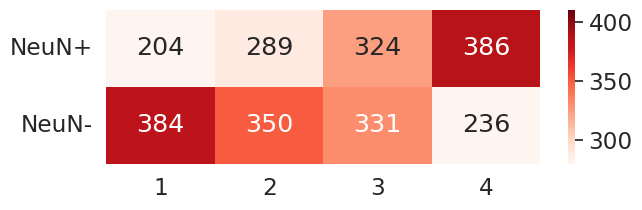

In [191]:
plt.figure(figsize=(7,2))
palette2 =sns.color_palette(palette="Reds", n_colors=200,as_cmap=True)
tss_in_loop_df.index =  [i +1 for i in tss_in_loop_df.index]
ax = sns.heatmap(loop_groups_statistics.T, annot=True, 
                 vmin = 280, vmax = 410,
                 fmt=".0f", cmap= palette2)

In [192]:
def preprocess_loops(df, columns, anchor, slopvalue=None):
    df_processed = df[columns].reset_index(drop=True)
    df_processed["anchor"] = anchor    
    if slopvalue and slopvalue > 0:
        df_slopped = pbt.from_dataframe(df_processed).slop(b=slopvalue, g='../data/hg38.chrom.sizes')
        df_processed = pd.read_table(df_slopped.fn, header=None, names=df_processed.columns.tolist())
        assert df_processed.shape[0] > 1, "Dataframe after slopping has less than 2 rows."
    
    return df_processed

def make_loops_annotation(all_loops_10_ext, slopvalue):
    columns1 = ["chrom1", "start1", "end1", "loop_num", "loop_group", "NeuN+/NeuN-"]
    columns2 = ["chrom2", "start2", "end2", "loop_num", "loop_group", "NeuN+/NeuN-"]
    all_loops_flat1 = preprocess_loops(all_loops_10_ext, columns1, 'right', slopvalue)
    all_loops_flat2 = preprocess_loops(all_loops_10_ext, columns2, 'left', slopvalue).rename(columns={"chrom2": "chrom1", "start2": "start1", "end2": "end1"})
    all_loops_flat = pd.concat([all_loops_flat1, all_loops_flat2]).drop_duplicates().sort_values("loop_num").reset_index(drop=True)
    all_loops_flat_for_mr1 = all_loops_flat1.drop(columns=["anchor", "loop_group"])
    all_loops_flat_for_mr2 = all_loops_flat2.rename(columns={"chrom1": "chrom2", "start1": "start2", "end1": "end2"}).drop(columns=["anchor", "NeuN+/NeuN-"])
    all_loops_flat_axis1 = pd.concat([all_loops_flat_for_mr1.drop(columns="loop_num"), all_loops_flat_for_mr2], axis=1).drop_duplicates().reset_index(drop=True)
    for df in [all_loops_flat1, all_loops_flat2]:
        df.columns = ['secrnd' + col if col != "loop_num" else col for col in df.columns]
    
    return all_loops_flat_axis1, all_loops_flat1, all_loops_flat2

In [215]:
def count_echnacer_promoter(de_neurons, loop_set, echancers_init):
    de_neurons.columns = [0, 1, 2, 3, 4, 5]
    echancers = echancers_init.copy()
    loops = loop_set[0]
    loops_flat1 = loop_set[1]
    loops_flat2 = loop_set[2] 
    df = make_intersect_loops2(loops, de_neurons)
    df2 = pd.concat([df[df.anchor == "left"].merge(loops_flat1, on  = "loop_num"),
            df[df.anchor == "right"].merge(loops_flat2, on  = "loop_num")])
    df2 = df2.rename(columns = {"loop_num":"secrndloop_num"})
    df2 = df2.drop(columns = ["NeuN+/NeuN-", 0,1,2,4,5])
    df3 = df2[df2.columns.tolist()[7:] + [df2.columns.tolist()[3]]]
    df_intersect2 = second_round_intersect(echancers, df3)
    df_check = df2.merge(df_intersect2, on = ["secrndloop_num", "secrndchrom1", "secrndstart1","secrndend1","secrndanchor"])
    df4 = df_check.loc[df_check[3] != df_check.secrnd3]
    df4["interation_num"] = [i for i in range(df4.shape[0])]
    df4_check2 = df4.drop_duplicates([3,"secrnd3"]).reset_index(drop=True)
    df4 = df4_check2.groupby(3).size().to_frame().reset_index().rename(columns = {3:"gene_name", 0:"num_promoter_interr"})
    
    df4 = extend_df(df4, de_neurons)
    return df4, df4_check2

def second_round_intersect_echnacer_promoter(de_neurons2, df3):
    de_neurons2.columns = ['secrnd'+str(i) for i in de_neurons2.columns.tolist()  ]
    df_intersect2 = pbt.from_dataframe(df3)\
                                        .intersect(pbt.from_dataframe(de_neurons2), wa=True, wb=True)
    df_intersect2 = pd.read_table(df_intersect2.fn, header = None, names = df3.columns.tolist() +de_neurons2.columns.tolist() )
    return df_intersect2

def ench_check(df4, loops_with_ench):
    ench_check = pd.concat([df4[["secrndloop_num","anchor", "interation_num"]] , 
    df4[["secrndloop_num","secrndanchor", "interation_num"]].rename(columns = {"secrndanchor":"anchor"})])
    ench_check["loop_anchor"] = [str(i) for i in ench_check["secrndloop_num"]] + ench_check["anchor"]
    ench_check = ench_check[~ench_check.loop_anchor.isin(loops_with_ench.loop_anchor.tolist())]
    df4 = df4[df4.interation_num.isin(ench_check.interation_num.tolist())]
    return df4

def extend_df(df4, de_neurons):
    genes= set(de_neurons[3].tolist()) - set(df4["gene_name"].tolist())
    genes = pd.DataFrame(zip(genes, [0]*len(genes)), columns = ["gene_name", "num_promoter_interr"])
    df = pd.concat([df4,genes]).drop_duplicates().sort_values("num_promoter_interr", ascending =False).reset_index(drop=True)
    return df
    
def make_intersect_loops2(df_sel, de_neurons):    
    df_right = df_sel[["chrom1","start1", "end1", "loop_num","loop_group", "NeuN+/NeuN-"]].copy()
    df_right["anchor"] = 'right'
    df_left = df_sel[["chrom2","start2", "end2", "loop_num", "loop_group", "NeuN+/NeuN-"]].rename(columns = {"chrom2":"chrom1","start2":"start1","end2":"end1"})
    df_left["anchor"] = 'left'
    df = pd.concat([df_right,
         df_left ])
    df = df.drop_duplicates().reset_index(drop=True)  
    colnames = df.columns.tolist()  + de_neurons.columns.tolist()
    df_intersect = pbt.from_dataframe(df)\
                                .intersect(pbt.from_dataframe(de_neurons), wa=True, wb = True)
    df_intersect = pd.read_table(df_intersect.fn, header = None, names=colnames)
    return df_intersect


def second_round_intersect(de_neurons2, df3):
    de_neurons2.columns = ['secrnd'+str(i) for i in de_neurons2.columns.tolist()  ]
    df_intersect2 = pbt.from_dataframe(df3)\
                                        .intersect(pbt.from_dataframe(de_neurons2), wa=True, wb=True)
    df_intersect2 = pd.read_table(df_intersect2.fn, header = None, names = df3.columns.tolist() +de_neurons2.columns.tolist() )
    return df_intersect2

In [194]:
all_loops_slopped2, all_loops_flat1_slopped2, all_loops_flat2_slopped2 = make_loops_annotation(all_loops_10_ext, 20000)
loop_set_slopped2 = [all_loops_slopped2, all_loops_flat1_slopped2, all_loops_flat2_slopped2]

In [196]:
columns = [0, 1, 2, 3, 4, 5]
enhancers_plus_ChromHMM = ChromHMM_Neuron[ChromHMM_Neuron.state == "EnhA"].iloc[:,:6]
enhancers_minus_ChromHMM = ChromHMM_NonNeuron[ChromHMM_NonNeuron.state == "EnhA"].iloc[:,:6]
enhancers_plus_ChromHMM.columns = columns
enhancers_minus_ChromHMM.columns = columns
enhancers_minus_ChromHMM[3] = [i for i in range(enhancers_minus_ChromHMM.shape[0])]
enhancers_plus_ChromHMM[3] = [i for i in range(enhancers_plus_ChromHMM.shape[0])]

In [214]:
ench_pr_plus, ench_pr_plus_check = count_echnacer_promoter(tss_plus, loop_set_slopped2, enhancers_plus_ChromHMM)
ench_pr_minus, ench_pr_minus_check = count_echnacer_promoter(tss_glia, loop_set_slopped2, enhancers_minus_ChromHMM)

In [221]:
ench_pr_minus_check_df = make_consice_table2(ench_pr_minus_check, loop_set_slopped2[0], tss_glia)
fr_minus = ench_frequency2(ench_pr_minus_check_df)
fr_minus.round(2)

,0,1,2,3
0,0.22,0.31,0.29,0.25
1-5,0.55,0.49,0.49,0.61
more than 5,0.23,0.20,0.22,0.15


In [222]:
ench_pr_minus_check_df = make_consice_table2(ench_pr_minus_check, loop_set_slopped2[0], tss_glia)
fr_plus = ench_frequency2(ench_pr_plus_check_df)
fr_plus.round(2)

,0,1,2,3
0,0.18,0.24,0.10,0.06
1-5,0.61,0.52,0.55,0.54
more than 5,0.21,0.24,0.35,0.40


Ench per DE gene, NeuN+


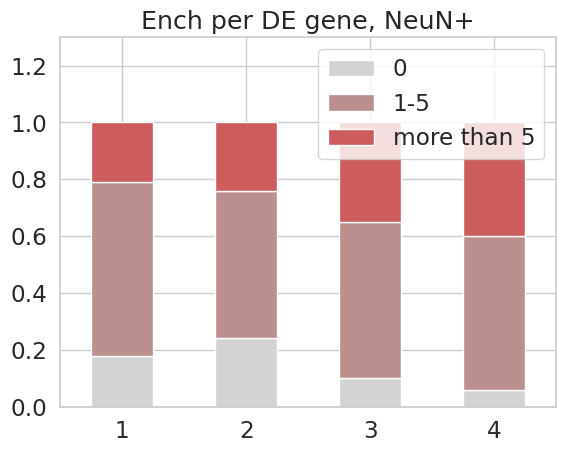

Ench per DE gene, NeuN-


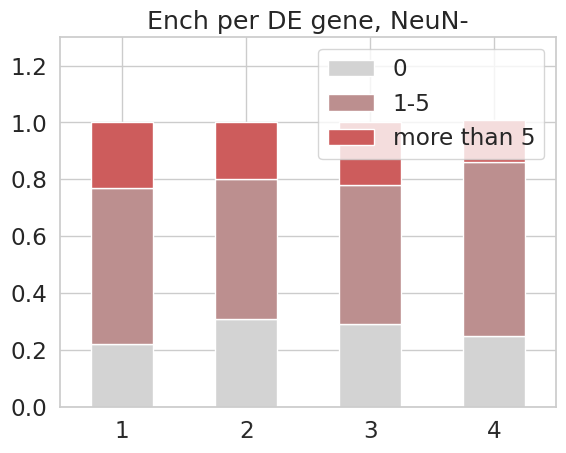

In [224]:
fr_plus.columns = ["1", "2","3","4"]
fr_minus.columns = ["1", "2","3","4"]

print("Ench per DE gene, NeuN+")
fr_plus.T.plot(kind='bar', title = "Ench per DE gene, NeuN+", 
                 rot = 0.5,
                 ylim = (0,1.3),stacked=True, 
                 color=['lightgrey', 'rosybrown', 'indianred'])
plt.show()

print("Ench per DE gene, NeuN-")
fr_minus.T.plot(kind='bar',  title = "Ench per DE gene, NeuN-", 
                rot = 0.5,
                ylim = (0,1.3), stacked=True, color=['lightgrey', 'rosybrown', 'indianred'])
plt.show() 